In [626]:
'''Loading packages'''
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from pylab import rcParams
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import gensim
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sebastiannw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sebastiannw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [160]:
# MAC USERS TAKE NOTE:
# For clearer plots in Jupyter notebooks on macs, run the following line of code:
%config InlineBackend.figure_format = 'retina'

In [109]:
'''Loading data'''
data_train = pd.read_csv('Data/imdb5k_train.csv')
data_test  = pd.read_csv('Data/imdb5k_test.csv')
stop_words = set(stopwords.words('english'))

In [441]:
'''Preprocessing data'''
documents_train = [row['text'].lower() for i, row in data_train.iterrows()]
documents_train = [re.findall(r'\b\w+\b', document) for document in documents_train]
documents_train = [[word for word in document if not word in stop_words] for document in documents_train]
labels_train    = [int(row['label'] == 'pos') for i, row in data_train.iterrows()]

documents_test = [row['text'].lower() for i, row in data_test.iterrows()]
documents_test = [re.findall(r'\b\w+\b', document) for document in documents_test]
documents_test = [[word for word in document if not word in stop_words] for document in documents_test]
labels_test    = [int(row['label'] == 'pos') for i, row in data_test.iterrows()]

positive_train = data_train[data_train['label'] == 'pos']
negative_train = data_train[data_train['label'] == 'neg']

positives_train = [row['text'].lower() for i, row in positive_train.iterrows()]
positives_train = [re.findall(r'\b\w+\b', document) for document in positives_train]
positives_train = [[word for word in document if not word in stop_words] for document in positives_train]

negatives_train = [row['text'].lower() for i, row in negative_train.iterrows()]
negatives_train = [re.findall(r'\b\w+\b', document) for document in negatives_train]
negatives_train = [[word for word in document if not word in stop_words] for document in negatives_train]

In [614]:
def lda_inference(documents: list, num_topics: int):
    '''
    Returns a trained LDA model for topic modeling inference given a list of documents where each document
    is a list of tokens.
    '''
    # Creating corpus with strings
    D = documents

    # Create a dictionary representation of the documents.
    dictionary = Dictionary(D)

    # Bag-of-words representation of the documents.
    corpus_bow = [dictionary.doc2bow(w) for w in D]

    # Make a index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.

    # Training model
    lda_model = LdaModel(corpus=corpus_bow, id2word=dictionary.id2token, chunksize=2000, alpha='auto',
                         eta='auto', iterations=400, num_topics=num_topics, passes=20, eval_every=None)
    
    return lda_model, corpus_bow

In [290]:
'''Training models to infer topics to later create synthetic data'''
positive_model, positive_corpus = lda_inference(positives_train, 5)
negative_model, negative_corpus = lda_inference(negatives_train, 5)

In [291]:
positive_model.print_topics()

[(0,
  '0.009*"film" + 0.005*"one" + 0.003*"characters" + 0.002*"jane" + 0.002*"story" + 0.002*"character" + 0.002*"well" + 0.002*"also" + 0.002*"batman" + 0.002*"part"'),
 (1,
  '0.004*"one" + 0.003*"team" + 0.003*"mildred" + 0.003*"back" + 0.003*"philip" + 0.003*"time" + 0.002*"tarzan" + 0.002*"man" + 0.002*"love" + 0.002*"mr"'),
 (2,
  '0.019*"movie" + 0.014*"film" + 0.010*"one" + 0.008*"like" + 0.008*"good" + 0.006*"well" + 0.006*"story" + 0.006*"great" + 0.006*"see" + 0.005*"time"'),
 (3,
  '0.008*"film" + 0.006*"one" + 0.005*"rob" + 0.004*"love" + 0.004*"roy" + 0.003*"man" + 0.003*"game" + 0.003*"two" + 0.003*"like" + 0.002*"time"'),
 (4,
  '0.010*"film" + 0.007*"one" + 0.003*"man" + 0.003*"time" + 0.003*"story" + 0.003*"also" + 0.003*"like" + 0.003*"would" + 0.003*"movie" + 0.003*"first"')]

In [292]:
negative_model.print_topics()

[(0,
  '0.018*"movie" + 0.016*"film" + 0.010*"one" + 0.008*"like" + 0.007*"bad" + 0.005*"even" + 0.005*"good" + 0.005*"really" + 0.005*"time" + 0.005*"would"'),
 (1,
  '0.025*"movie" + 0.007*"film" + 0.007*"one" + 0.007*"like" + 0.006*"good" + 0.006*"even" + 0.005*"would" + 0.005*"really" + 0.005*"bad" + 0.004*"time"'),
 (2,
  '0.009*"bridget" + 0.004*"queen" + 0.004*"rod" + 0.003*"andrew" + 0.003*"grams" + 0.003*"one" + 0.003*"stefan" + 0.003*"huggins" + 0.003*"mirror" + 0.002*"charlie"'),
 (3,
  '0.005*"dillinger" + 0.003*"also" + 0.003*"nelson" + 0.003*"face" + 0.003*"movie" + 0.003*"john" + 0.003*"baby" + 0.002*"killed" + 0.002*"one" + 0.002*"know"'),
 (4,
  '0.012*"film" + 0.007*"one" + 0.005*"show" + 0.004*"like" + 0.004*"much" + 0.003*"would" + 0.003*"even" + 0.003*"good" + 0.003*"also" + 0.002*"two"')]

In [617]:
def get_topic_data(dataset, model, corpus):
    '''
    Function to transform text data into its topic distribution according to a model trained on
    that data and a corpus made with that dataset.
    '''
    topic_data = np.zeros((len(dataset), 5))

    for i in range(len(dataset)):
        output = model[corpus[i]]
        for j in range(len(output)):
            topic_data[i][output[j][0]] = output[j][1]
    
    return topic_data

In [334]:
'''Retrieving tokens for positive and negative comments'''
positive_tokens = []
for i in range(len(positive_model.print_topics())):
    positive_tokens += re.findall(r'\b[A-Za-z]+\b', positive_model.print_topics()[i][1])
positive_tokens = list(set(positive_tokens))
print(positive_tokens)
    
negative_tokens = []
for i in range(len(negative_model.print_topics())):
    negative_tokens += re.findall(r'\b[A-Za-z]+\b', negative_model.print_topics()[i][1])
negative_tokens = list(set(negative_tokens))
print(negative_tokens)

['love', 'would', 'mr', 'two', 'rob', 'film', 'team', 'roy', 'mildred', 'good', 'philip', 'time', 'story', 'man', 'one', 'batman', 'characters', 'jane', 'character', 'also', 'game', 'great', 'well', 'first', 'part', 'movie', 'back', 'see', 'like', 'tarzan']
['would', 'two', 'grams', 'film', 'face', 'andrew', 'huggins', 'like', 'good', 'queen', 'rod', 'time', 'much', 'know', 'bad', 'one', 'even', 'bridget', 'stefan', 'also', 'really', 'dillinger', 'baby', 'movie', 'mirror', 'nelson', 'john', 'killed', 'charlie', 'show']


In [399]:
def lda_generative(vocabulary: list, beta: np.array, alpha: list, xi: int):
    '''
    Generative LDA function. Creates synthetic data according to a vocabulary, a beta topic-word matrix
    with the word (columns) distributions per topic (rows), a topic frequency list alpha and a mean sentence length
    xi.
    '''
    theta = np.random.dirichlet(alpha)
    N = np.random.poisson(xi)
    w = []
    for x in range(N):
        z_experiment = np.random.multinomial(1, theta)
        z            = np.where(z_experiment == 1)[0][0]
        y_experiment = np.random.multinomial(1, beta[z, :])
        y            = np.where(y_experiment == 1)[0][0]
        w.append(vocabulary[y])
    return w

In [517]:
'''Creating synthetic positive data with LDA generative model'''
pos_vocabulary = positive_tokens

pos_beta = np.array([
    [0, 0, 0, 0, 0,  9, 0, 0, 0, 0, 0, 0, 2, 0,  5, 2, 3, 2, 2, 2, 0, 0, 2, 0, 2,  0, 0, 0, 0, 0],
    [2, 0, 2, 0, 0,  0, 3, 0, 3, 0, 3, 3, 0, 2,  4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 3, 0, 0, 2],
    [0, 0, 0, 0, 0, 14, 0, 0, 0, 8, 0, 5, 6, 0, 10, 0, 0, 0, 0, 0, 0, 6, 6, 0, 0, 19, 0, 6, 8, 0],
    [4, 0, 0, 3, 5,  8, 0, 4, 0, 0, 0, 2, 0, 3,  6, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,  0, 0, 0, 3, 0],
    [0, 3, 0, 0, 0, 10, 0, 0, 0, 0, 0, 3, 3, 3,  7, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0,  3, 0, 0, 3, 0]
])
pos_beta = pos_beta.astype(float)
for i in range(5):
    pos_beta[i] = pos_beta[i] / np.sum(pos_beta[i])

pos_topic_data = get_topic_data(positives_train, positive_model, positive_corpus)
pos_alpha      = np.sum(pos_topic_data, axis=0).astype(int)

pos_tot = 0
for x in positives_train:
    pos_tot += len(x)
pos_xi = int(pos_tot / len(positives_train))

positives_synth = [lda_generative(pos_vocabulary, pos_beta, pos_alpha, pos_xi) for x in range(5000)]

In [518]:
'''Creating synthetic negative data with LDA generative model'''
neg_vocabulary = negative_tokens

neg_beta = np.array([
    [5, 0, 0, 16, 0, 0, 0, 8, 5, 0, 0, 5, 0, 0, 7, 10, 5, 0, 0, 0, 5, 0, 0, 18, 0, 0, 0, 0, 0, 0],
    [5, 0, 0,  7, 0, 0, 0, 7, 6, 0, 0, 4, 0, 0, 5,  7, 6, 0, 0, 0, 5, 0, 0, 25, 0, 0, 0, 0, 0, 0],
    [0, 0, 3,  0, 0, 3, 3, 0, 0, 4, 4, 0, 0, 0, 0,  3, 0, 9, 3, 0, 0, 0, 0,  0, 3, 0, 0, 0, 2, 0],
    [0, 0, 0,  0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,  2, 0, 0, 0, 3, 0, 5, 3,  3, 0, 3, 3, 2, 0, 0],
    [3, 2, 0, 12, 0, 0, 0, 4, 3, 0, 0, 0, 4, 0, 0,  7, 3, 0, 0, 3, 0, 0, 0,  0, 0, 0, 0, 0, 0, 5]
])
neg_beta = neg_beta.astype(float)
for i in range(5):
    neg_beta[i] = neg_beta[i] / np.sum(neg_beta[i])

neg_topic_data = get_topic_data(negatives_train, negative_model, negative_corpus)
neg_alpha      = np.sum(neg_topic_data, axis=0).astype(int)

neg_tot = 0
for x in negatives_train:
    neg_tot += len(x)
neg_xi = int(neg_tot / len(negatives_train))

negatives_synth = [lda_generative(neg_vocabulary, neg_beta, neg_alpha, neg_xi) for x in range(5000)]

In [521]:
'''Creating synthetic datasets'''
documents_synth = positives_synth + negatives_synth
labels_synth    = [1 for x in range(len(positives_synth))] + [0 for x in range(len(negatives_synth))]

documents_synth, labels_synth = shuffle(documents_synth, labels_synth, random_state=1)

doc_synth_train, doc_synth_test, lbl_synth_train, lbl_synth_test = train_test_split(
    documents_synth, labels_synth, test_size=0.5, random_state=1
)

txt_synth_train = []
for doc in doc_synth_train:
    txt = ''
    for word in doc:
        txt += word + ' '
    txt_synth_train.append(txt)
    
synth_train = pd.DataFrame(data={'label': lbl_synth_train, 'text': txt_synth_train})
synth_train.loc[synth_train['label'] == 1, 'label'] = 'pos'
synth_train.loc[synth_train['label'] == 0, 'label'] = 'neg'
synth_train.to_csv('Data/synth_train.csv', index=False)

txt_synth_test = []
for doc in doc_synth_test:
    txt = ''
    for word in doc:
        txt += word + ' '
    txt_synth_test.append(txt)

synth_test = pd.DataFrame(data={'label': lbl_synth_test, 'text': txt_synth_test})
synth_test.loc[synth_test['label'] == 1, 'label'] = 'pos'
synth_test.loc[synth_test['label'] == 0, 'label'] = 'neg'
synth_test.to_csv('Data/synth_test.csv', index=False)

In [657]:
'''Training models to infer topics from real and synthetic datasets'''
real_model, real_corpus   = lda_inference(documents_train, 5)
synth_model, synth_corpus = lda_inference(doc_synth_train, 5)

In [658]:
real_model.print_topics()

[(0,
  '0.002*"lugosi" + 0.002*"back" + 0.002*"tarzan" + 0.002*"rock" + 0.002*"jane" + 0.001*"water" + 0.001*"stewart" + 0.001*"astaire" + 0.001*"man" + 0.001*"rukh"'),
 (1,
  '0.017*"movie" + 0.014*"film" + 0.010*"one" + 0.008*"like" + 0.006*"good" + 0.005*"time" + 0.005*"even" + 0.005*"would" + 0.005*"story" + 0.004*"really"'),
 (2,
  '0.003*"family" + 0.002*"father" + 0.002*"brother" + 0.002*"japanese" + 0.002*"bridget" + 0.002*"mother" + 0.002*"son" + 0.002*"mildred" + 0.002*"charlie" + 0.002*"philip"'),
 (3,
  '0.007*"film" + 0.003*"man" + 0.003*"war" + 0.003*"life" + 0.003*"love" + 0.002*"story" + 0.002*"two" + 0.002*"also" + 0.002*"play" + 0.002*"world"')]

In [659]:
synth_model.print_topics()

[(0,
  '0.181*"film" + 0.163*"movie" + 0.129*"one" + 0.074*"like" + 0.061*"story" + 0.059*"good" + 0.058*"time" + 0.047*"well" + 0.047*"great" + 0.043*"see"'),
 (1,
  '0.174*"film" + 0.138*"movie" + 0.138*"one" + 0.089*"like" + 0.072*"story" + 0.063*"time" + 0.057*"good" + 0.051*"see" + 0.048*"well" + 0.037*"great"'),
 (2,
  '0.198*"movie" + 0.190*"film" + 0.119*"one" + 0.098*"like" + 0.070*"good" + 0.065*"bad" + 0.055*"even" + 0.052*"time" + 0.050*"would" + 0.047*"really"'),
 (3,
  '0.220*"movie" + 0.160*"film" + 0.112*"one" + 0.086*"like" + 0.070*"bad" + 0.067*"even" + 0.064*"would" + 0.059*"good" + 0.056*"really" + 0.049*"time"')]

In [660]:
def get_test_corpus(documents_train, documents_test):
    '''Function to return a test corpus based on a train dictionary'''
    D = documents_train
    dictionary = Dictionary(D)
    corpus_bow = [dictionary.doc2bow(w) for w in documents_test]
    
    return corpus_bow

In [661]:
'''Preparing data for classifier'''
real_train = get_topic_data(documents_train, real_model, real_corpus)
real_test  = get_topic_data(documents_test, real_model, get_test_corpus(documents_train, documents_test))

synth_train = get_topic_data(doc_synth_train, synth_model, synth_corpus)
synth_test  = get_topic_data(doc_synth_test, synth_model, get_test_corpus(doc_synth_train, doc_synth_test))

In [662]:
'''Training Logistic Regression classifier with real data'''
real_classifier = LogisticRegression(solver='liblinear', max_iter=10**4)
real_classifier.fit(real_train, np.array(labels_train))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [663]:
np.sum(real_classifier.predict(real_train) == np.array(labels_train)) / len(labels_train)

0.61

In [664]:
'''Training Logistic Regression classifier with synthetic data'''
synth_classifier = LogisticRegression(solver='liblinear', max_iter=10**4)
synth_classifier.fit(synth_train, np.array(lbl_synth_train))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [665]:
np.sum(real_classifier.predict(synth_train) == np.array(lbl_synth_train)) / len(lbl_synth_train)

0.3492

<br>

## Appendix

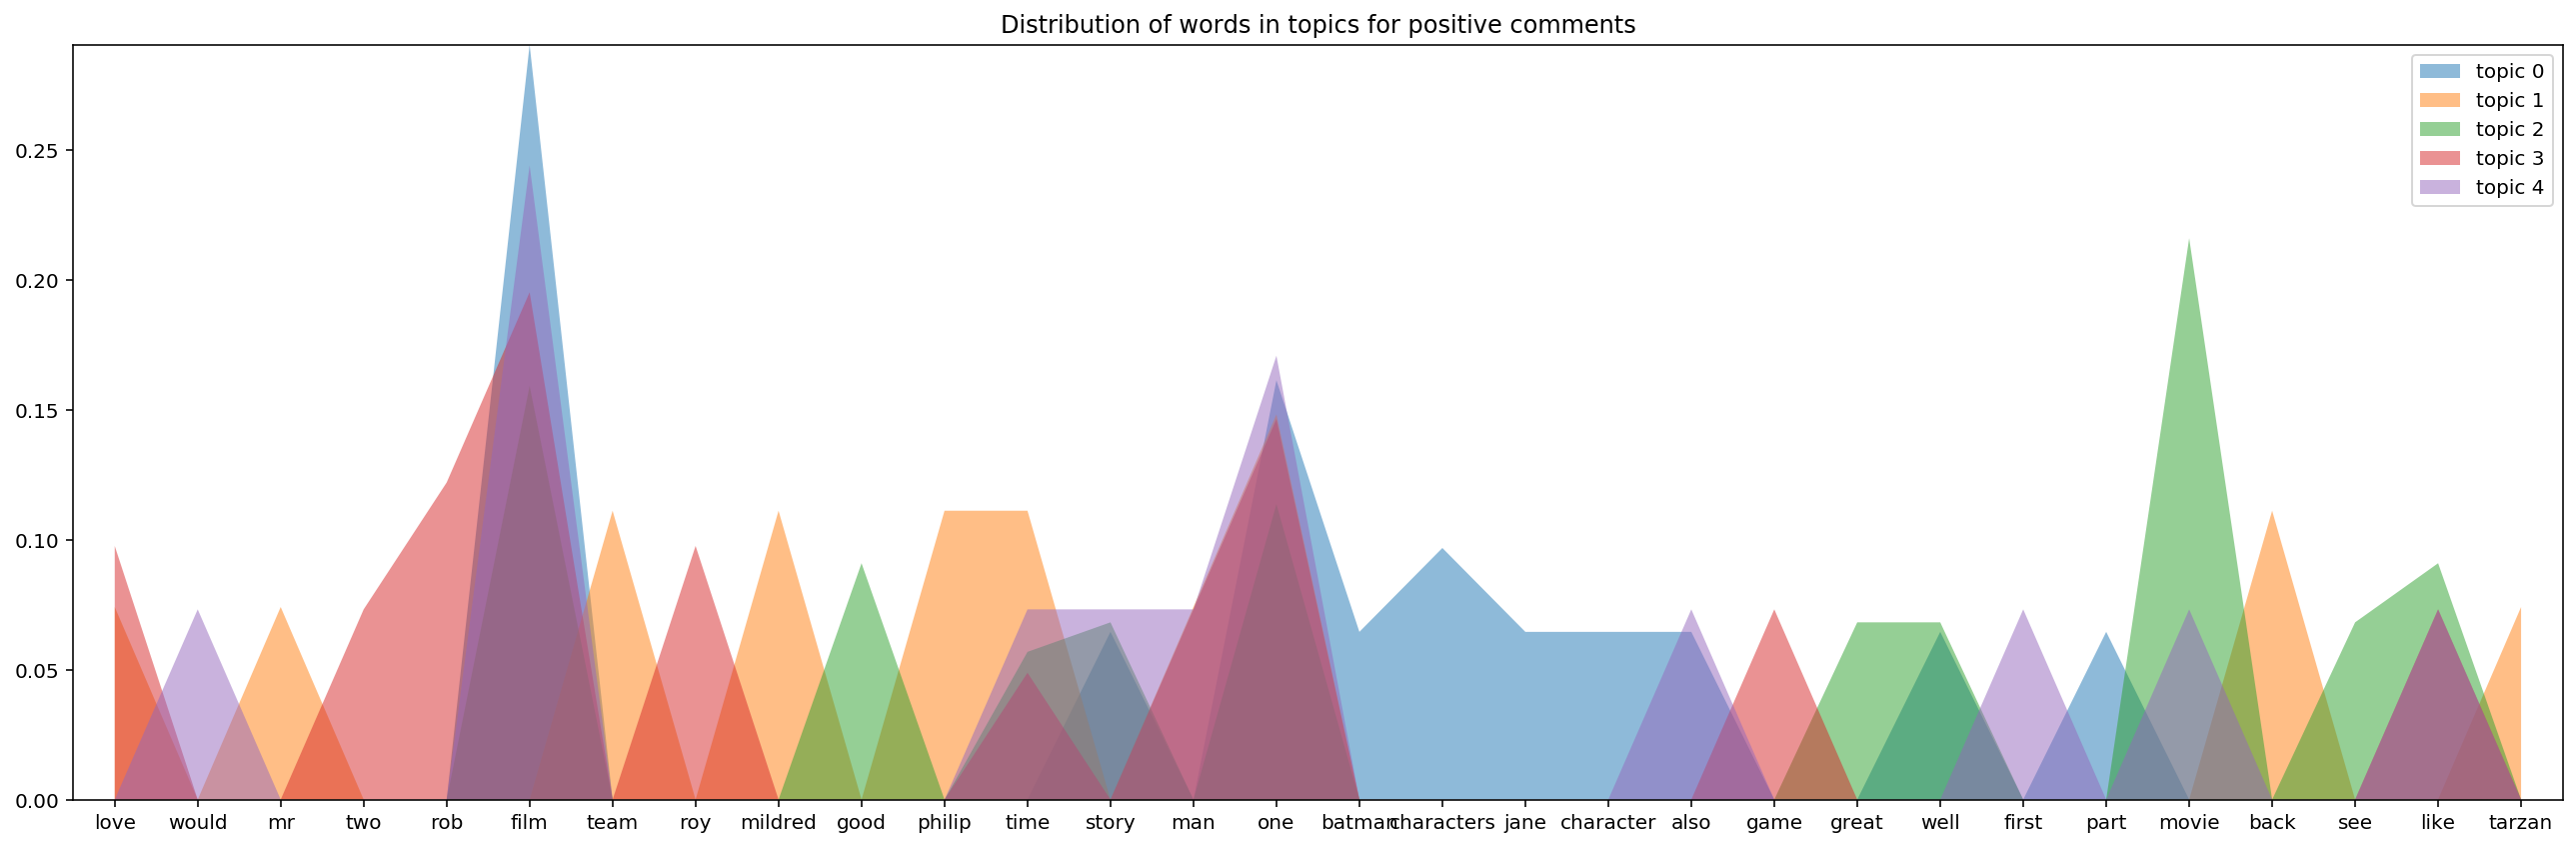

In [430]:
'''Plotting distribution of words in topics for positive comments'''
colors = ['#eac435', '#345995', '#e40066']
rcParams['figure.figsize'] = 18, 6
plt.figure()
plt.title('Distribution of words in topics for positive comments')
plt.fill_between(positive_tokens, pos_beta[0], alpha=0.5, label='topic 0')
plt.fill_between(positive_tokens, pos_beta[1], alpha=0.5, label='topic 1')
plt.fill_between(positive_tokens, pos_beta[2], alpha=0.5, label='topic 2')
plt.fill_between(positive_tokens, pos_beta[3], alpha=0.5, label='topic 3')
plt.fill_between(positive_tokens, pos_beta[4], alpha=0.5, label='topic 4')
plt.legend()
plt.xlim(0 - 0.5, pos_beta.shape[1] - 0.5)
plt.ylim(0, np.max(pos_beta))
plt.tight_layout()
plt.show()

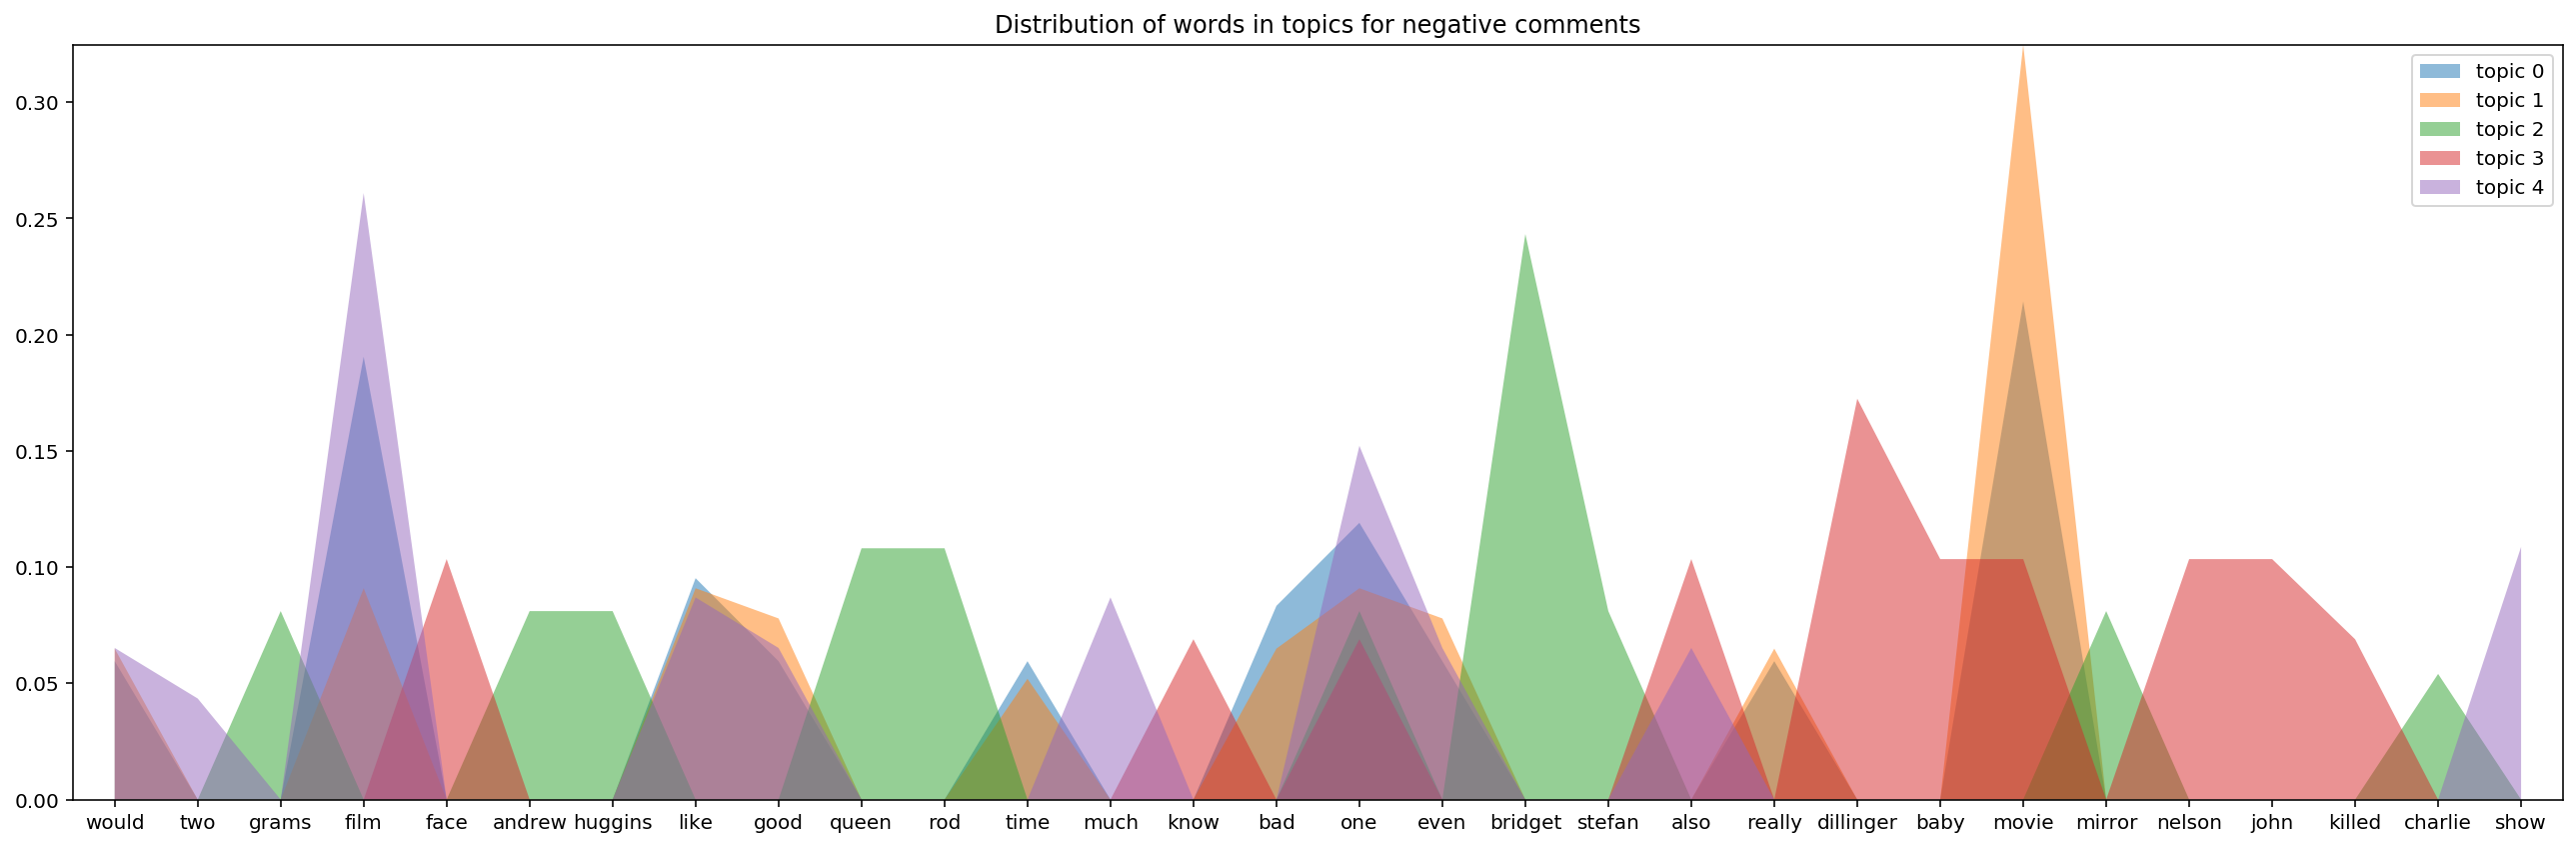

In [431]:
'''Plotting distribution of words in topics for negative comments'''
colors = ['#eac435', '#345995', '#e40066']
rcParams['figure.figsize'] = 18, 6
plt.figure()
plt.title('Distribution of words in topics for negative comments')
plt.fill_between(negative_tokens, neg_beta[0], alpha=0.5, label='topic 0')
plt.fill_between(negative_tokens, neg_beta[1], alpha=0.5, label='topic 1')
plt.fill_between(negative_tokens, neg_beta[2], alpha=0.5, label='topic 2')
plt.fill_between(negative_tokens, neg_beta[3], alpha=0.5, label='topic 3')
plt.fill_between(negative_tokens, neg_beta[4], alpha=0.5, label='topic 4')
plt.legend()
plt.xlim(0 - 0.5, neg_beta.shape[1] - 0.5)
plt.ylim(0, np.max(neg_beta))
plt.tight_layout()
plt.show()